In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from numpy import mean
from pandas_profiling import ProfileReport
from matplotlib.pyplot import figure

%run utils.ipynb
%run predict.ipynb

figure(num=None, figsize=(20, 16), dpi=80, facecolor='w', edgecolor='k')

df = pd.read_csv('./data/train.csv')

# GBefore everything we count the number of missing values in the dataframe
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Figure size 1600x1280 with 0 Axes>

In [2]:
# It seems like Age and Cabin have a lot of missing data, let's put more numbers into that
print('{}% of Age content is missing'.format(df['Age'].isnull().sum()/len(df)))
print('{}% of Cabin content is missing'.format(df['Cabin'].isnull().sum()/len(df)))
print('{}% of Embarked content is missing'.format(df['Embarked'].isnull().sum()/len(df)))

0.19865319865319866% of Age content is missing
0.7710437710437711% of Cabin content is missing
0.002244668911335578% of Embarked content is missing


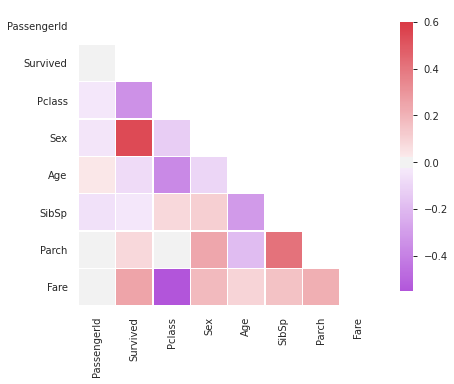

In [3]:
# Cabin has a very high percentage of missing data, we can not work with that level, we drop it
# df.drop('Cabin', inplace=True)

# Embarked has a very low percentage of missing data, we can deal with it

# Therefore, we can numerize sex table
df = numerize_sex(df)

# Age has around 20%, which can cause huge gaps in our predictions
# Let's first see the correlation between age and passengers who survived
correlation_graph(df)

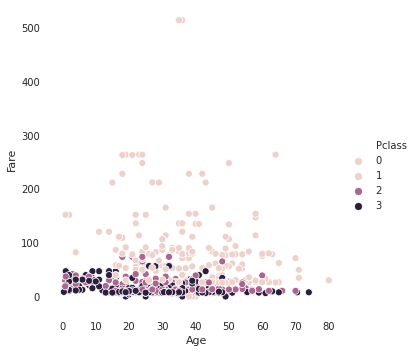

In [4]:
# We can see a positive correlation between age and passenger id, but a bit negative with survived
# WThere is also no way to retrieve age content
# At this point, impossible to fill missing values with "mean" as it makes absolutely no sense
# Therefore, we see that age has a positive correlation with Fare, from that, we can investigate
ax = sns.relplot(x='Age', y='Fare', hue='Pclass', data=df)

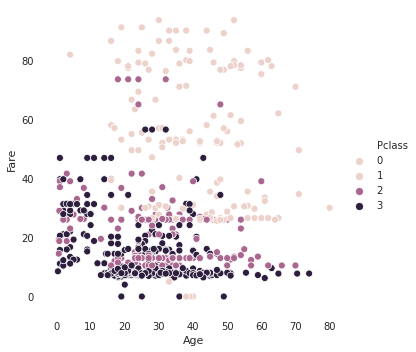

In [5]:
# PClass=0 does not exists, the library just labelled it
# What data tells us is above 100$ we only have passengers of first class, those we can classify as RICH
df = create_rich_category(df)

# Lets define other classes by comparing age and fares below 100
ax = sns.relplot(x='Age', y='Fare', hue='Pclass', data=df.query('Fare < 100'))

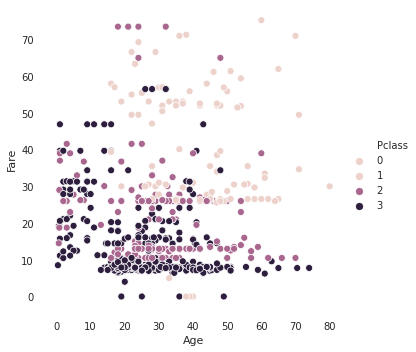

In [6]:
# We realize that from closed to 76 we still have rich people. We have to refine our category
df = update_rich_category(df)

# Lets define again other classes by comparing age and fares below 100
ax = sns.relplot(x='Age', y='Fare', hue='Pclass', data=df.query('Fare < 76'))

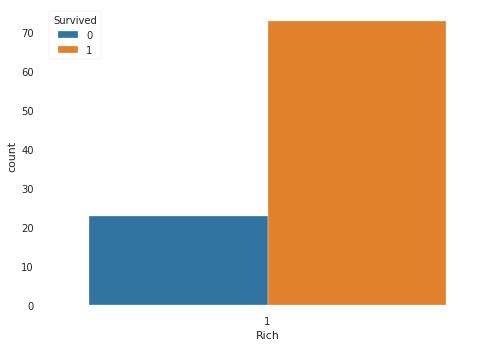

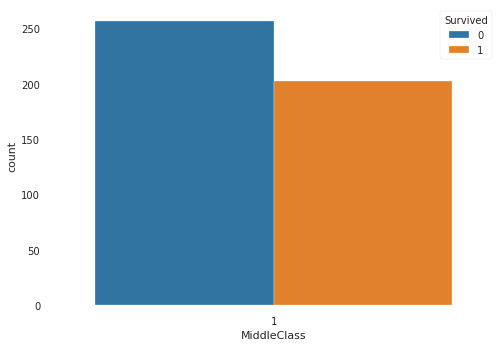

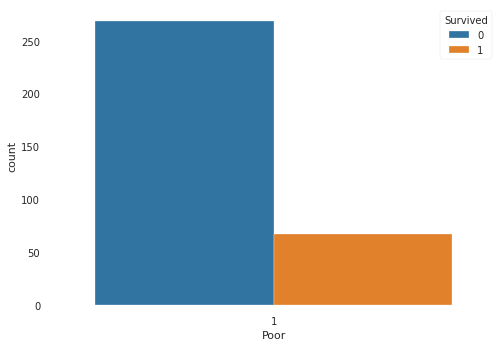

In [7]:
# Below 10 we can categorize those people as economically poor
df = create_poor_category(df)

# From 76 back to 10, we can considere those people as middle class
df = create_middleclass_category(df)

# I would like to see who survived amongst social layers
aa = sns.countplot(x='Rich', hue='Survived', data=df.query('Rich==1'))
plt.show()
ab = sns.countplot(x='MiddleClass', hue='Survived', data=df.query('MiddleClass==1'))
plt.show()
ac = sns.countplot(x='Poor', hue='Survived', data=df.query('Poor==1'))
plt.show()

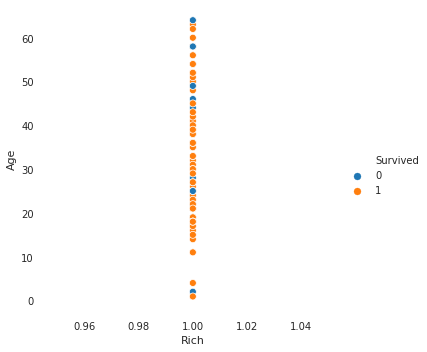

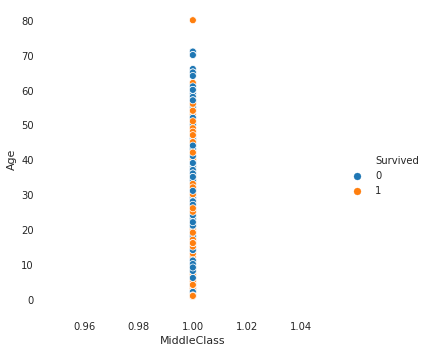

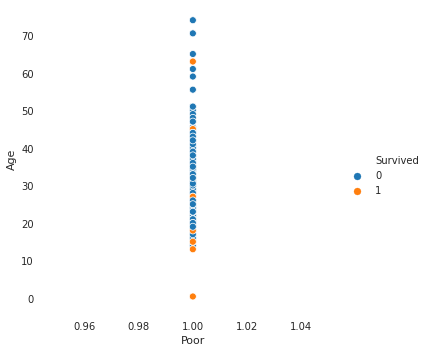

In [8]:
# Rich people have higher chances to survive than the middle class and poor dudes
# We spotted an hidden correlation, which is great
# Next step, we would like to see which age from each group has better chances to survive
ax = sns.relplot(x='Rich', y='Age', hue='Survived', data=df.query('Rich == 1'))
ax = sns.relplot(x='MiddleClass', y='Age', hue='Survived', data=df.query('MiddleClass == 1'))
ax = sns.relplot(x='Poor', y='Age', hue='Survived', data=df.query('Poor == 1'))

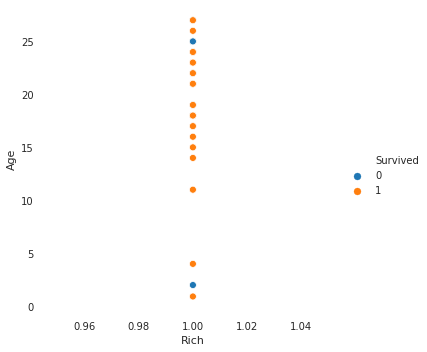

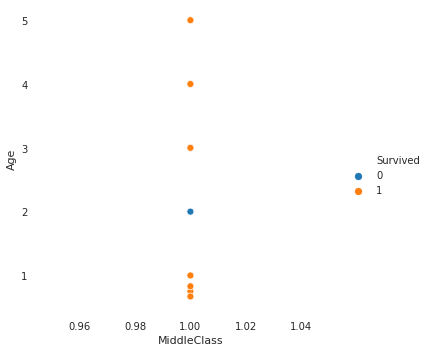

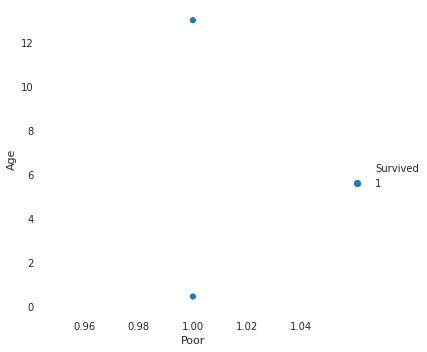

In [9]:
# Again, the poorer you are, the lower your chances to survive, but depending on your social rank, the survival age range varies a lot
# Lets confirm it
ax = sns.relplot(x='Rich', y='Age', hue='Survived', data=df.query('Rich == 1 & Age<28'))
ax = sns.relplot(x='MiddleClass', y='Age', hue='Survived', data=df.query('MiddleClass == 1 & Age<6'))
ax = sns.relplot(x='Poor', y='Age', hue='Survived', data=df.query('Poor == 1 & Age<14'))

In [10]:
# We create another category 'NaturalSelection', it looks like women and children first, lets confirm it
df = create_rich_age_selection(df)
df = create_middleclass_age_selection(df)
df = create_poor_age_selection(df)

Survival number by gender when Rich


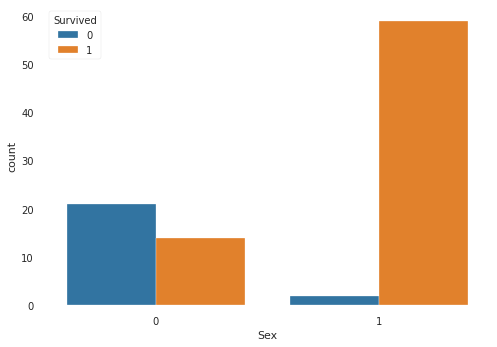

Survival number by gender when MiddleClass


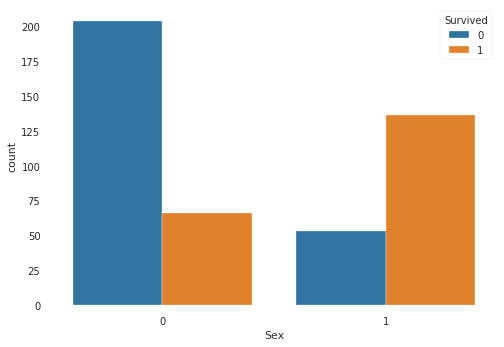

Survival number by gender when Poor


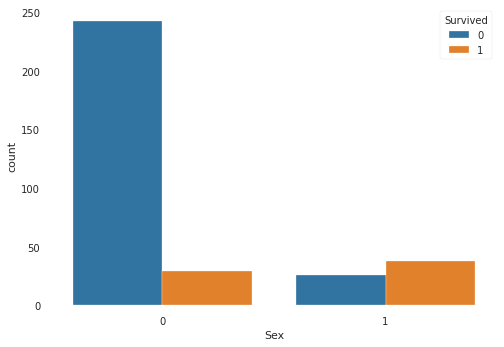

In [11]:
# Now, we want to know how many males and females survived in each social category
aa = sns.countplot(x='Sex', hue='Survived', data=df.query('Rich==1'))
print('Survival number by gender when Rich')
plt.show()
aa = sns.countplot(x='Sex', hue='Survived', data=df.query('MiddleClass==1'))
print('Survival number by gender when MiddleClass')
plt.show()
aa = sns.countplot(x='Sex', hue='Survived', data=df.query('Poor==1'))
print('Survival number by gender when Poor')
plt.show()

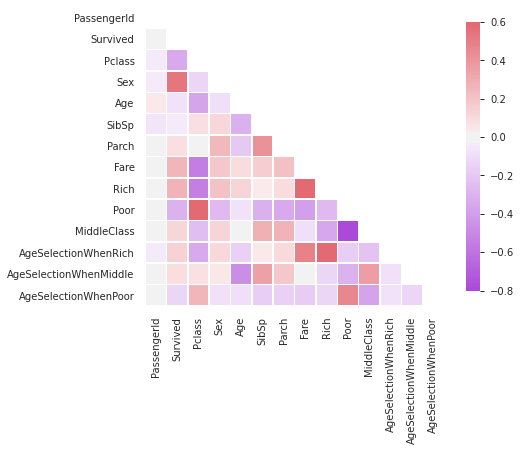

In [12]:
# Data tells us that if you are a rich woman, you have greater chances to survive than all other categories
# But we can not really deal with this data, as it is not significant enough for accuracy
# Let's plot a correlation graph again, to see what we are probably missing
correlation_graph(df)

Rich FamilySize that survived


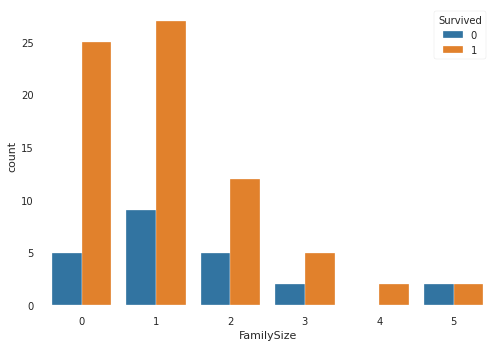

MiddleClass FamilySize that survived


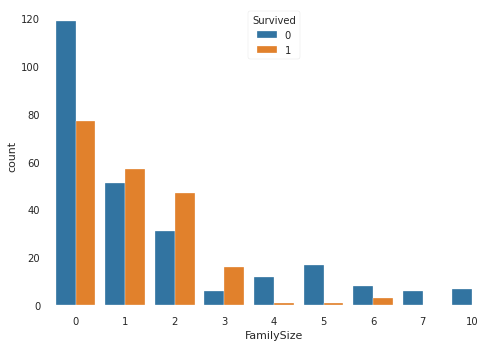

Poor FamilySize that survived


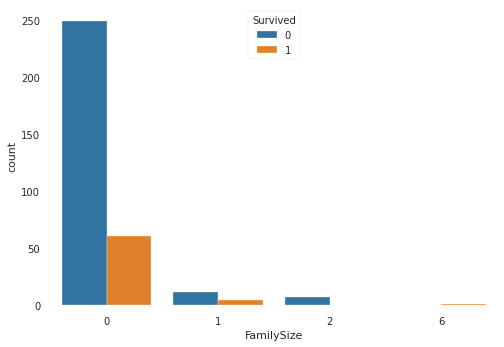

In [13]:
# Here, I just look at the column 'Survived' on x axis, and strangely I see low correlaton with Poor people and AgeSelectionWhenPoor
# that is because your age won't help you much to survive when you are poor
# We then need a new way to categorize them
# Parent-Children, Sibling-Spouse are all members of a same family
# Since those are just numbers, we can create a new column "FamilySize"
df = create_familysize_category(df)

# Alright, now we want to see for each social category, which familySize has better chance to survive
aa = sns.countplot(x='FamilySize', hue='Survived', data=df.query('Rich==1'))
print('Rich FamilySize that survived')
plt.show()
aa = sns.countplot(x='FamilySize', hue='Survived', data=df.query('MiddleClass==1'))
print('MiddleClass FamilySize that survived')
plt.show()
aa = sns.countplot(x='FamilySize', hue='Survived', data=df.query('Poor==1'))
print('Poor FamilySize that survived')
plt.show()

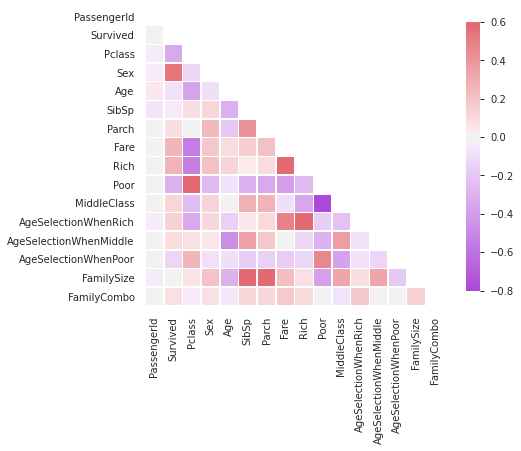

In [14]:
# Data tells us we have a 100% survival ratio when you are part of:
#  - rich family composed of 4 members
#  - poor family composed of 6 members
df = create_familycombo_category(df)

# Let's plot our correlation chart again and see what's going on
correlation_graph(df)

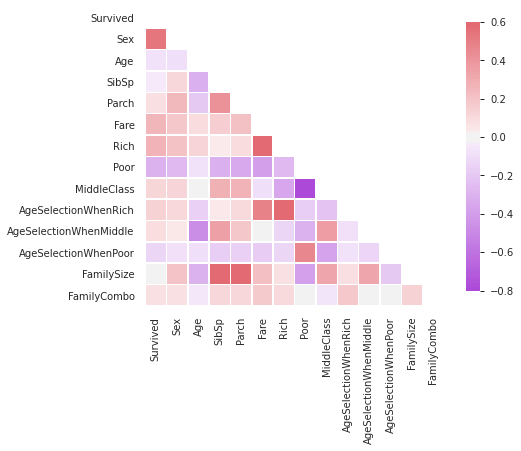

In [15]:
# We can see that familyCombo has a good correlation with Survived, compared to familySize
# therefore we can already remove PassengerId,Pclass columns as they get few correlation with Survived passengers
df = drop_passengerid_and_class(df)

correlation_graph(df)

In [16]:
# GREAT !!! But at this point, we still have no way to categorize which type of men and women survived
# We need this for better accuracy
# Best way to categorize it is to extract titles from column Name, it is an ant work, lets do it
df = create_title_category(df)

print(df['Title'].values)

[0 3 2 3 0 0 0 1 3 3 2 2 0 0 2 3 1 0 3 3 0 0 2 0 2 3 0 0 2 0 6 3 2 0 0 0 0
 0 2 2 3 3 0 2 2 0 0 2 0 3 1 0 3 3 0 0 2 0 2 1 0 2 0 1 0 1 3 0 2 0 0 2 0 0
 0 0 0 0 1 2 0 0 2 0 2 3 0 0 2 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 0 0 2 0 0 2 0
 2 0 2 2 0 0 0 0 2 0 0 0 2 0 1 0 0 2 0 0 0 3 3 0 0 2 0 0 0 3 2 3 0 0 0 0 2
 0 5 5 3 0 0 0 0 2 0 0 1 0 3 0 0 1 1 3 3 0 0 0 1 2 0 0 0 1 2 0 0 2 0 1 1 2
 0 3 0 0 0 3 0 2 1 3 2 0 0 2 2 0 0 0 0 0 2 0 0 2 0 0 2 0 0 0 2 2 0 2 0 0 0
 0 0 0 0 0 0 0 2 3 0 0 2 0 2 0 2 0 0 2 2 0 0 0 4 2 3 0 5 0 3 0 0 3 3 3 2 2
 3 0 1 0 0 2 0 0 0 3 2 0 0 3 0 2 2 2 0 1 3 0 0 0 0 0 0 0 0 0 2 2 3 0 2 0 0
 0 2 0 3 2 0 0 2 0 1 2 3 0 2 2 2 3 0 0 2 3 4 2 3 0 0 2 3 0 2 0 3 3 2 2 0 0
 0 3 0 0 2 0 0 1 2 0 0 0 2 2 3 1 0 0 0 0 0 0 0 2 2 2 2 0 0 3 0 0 0 3 3 2 7
 0 0 0 0 2 3 2 0 0 0 2 2 0 3 0 0 1 2 0 2 0 0 0 2 3 0 2 0 4 3 0 0 2 0 2 0 0
 1 0 2 0 0 2 0 0 3 3 2 0 2 0 0 0 3 0 0 3 2 0 0 0 3 3 0 0 2 2 3 0 0 3 0 0 9
 0 1 2 0 2 8 0 0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 0 0 2 0 0 3 3 2 0 0 0 0 2 1
 0 0 3 0 2 3 0 0 1 0 0 0 

Titles that survived within rich people


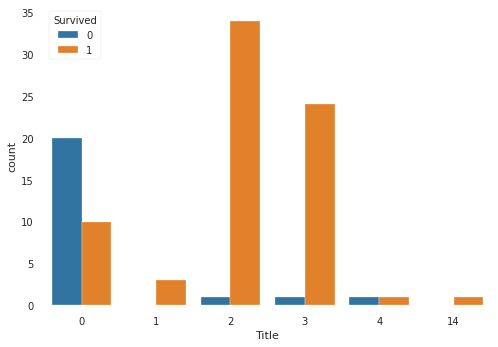

Titles that survived within middle class


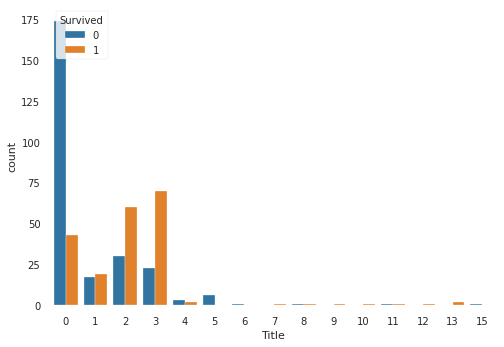

Titles that survived within poor people


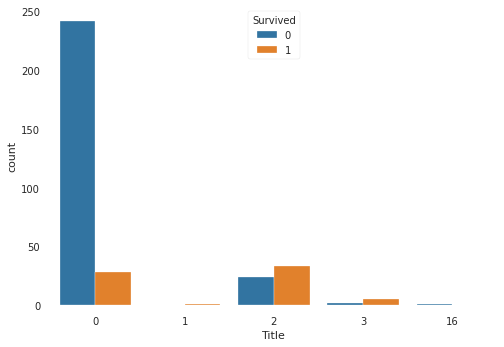

In [17]:
# Brilliant! Now all the titles have been extracted, lets define the titles with the highest chances to survive per social layer
aa = sns.countplot(x='Title', hue='Survived', data=df.query('Rich==1'))
print('Titles that survived within rich people')
plt.show()
aa = sns.countplot(x='Title', hue='Survived', data=df.query('MiddleClass==1'))
print('Titles that survived within middle class')
plt.show()
aa = sns.countplot(x='Title', hue='Survived', data=df.query('Poor==1'))
print('Titles that survived within poor people')
plt.show()

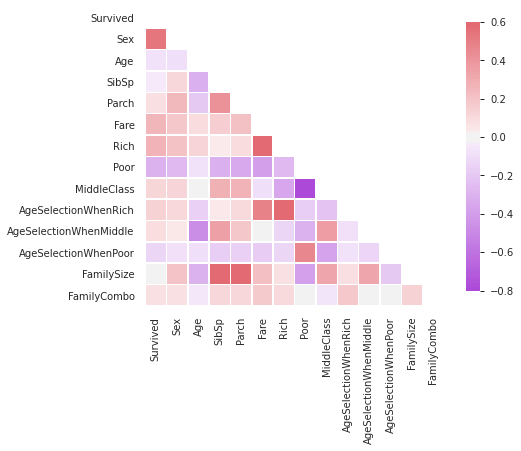

In [18]:
# Before doing anything else, let's see what our correlation grapth tells us
correlation_graph(df)

Rich passengers + Embarked VS survived


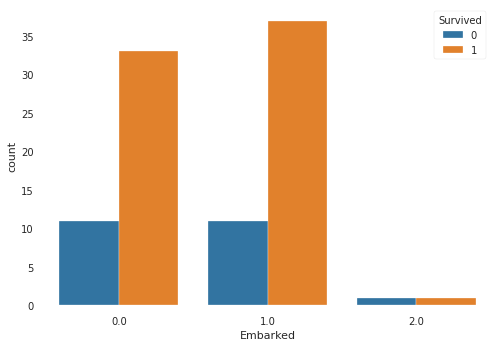

Middle class passengers + Embarked VS survived


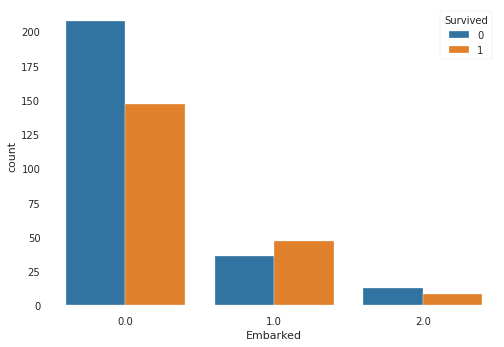

Poor passengers + Embarked VS survived


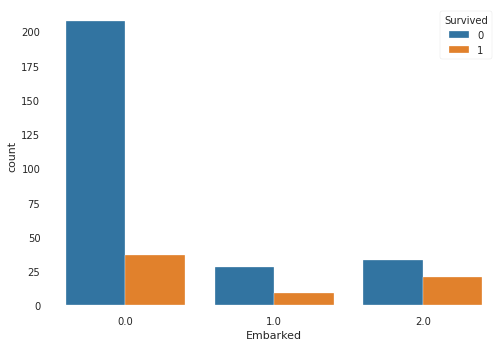

In [19]:
# There is a very high correlation between passengers title and their chance of surviving
# Now let's explore the rest of data to chase some correlations
# We start from where passengers embarked and we compare their survival rate per social layer

# Before we convert the Embarked feature
df = numerize_embarked(df)

aa = sns.countplot(x='Embarked', hue='Survived', data=df.query('Rich==1'))
print('Rich passengers + Embarked VS survived')
plt.show()

aa = sns.countplot(x='Embarked', hue='Survived', data=df.query('MiddleClass==1'))
print('Middle class passengers + Embarked VS survived')
plt.show()

aa = sns.countplot(x='Embarked', hue='Survived', data=df.query('Poor==1'))
print('Poor passengers + Embarked VS survived')
plt.show()

Rich passengers who embarked from Southampton + Title VS survived


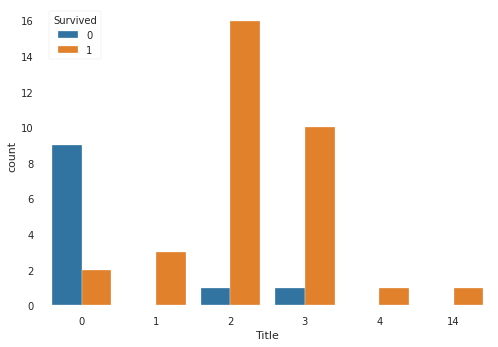

Rich passengers who embarked from Cherbourg + Title VS survived


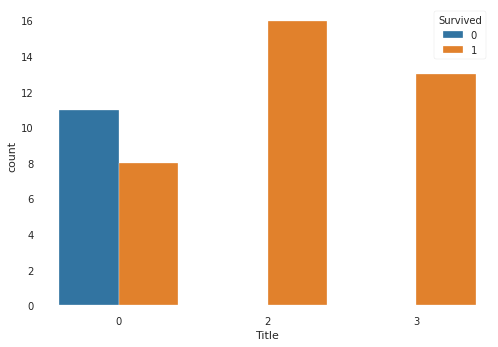

Middle class passengers who embarked from Southampton + Title VS survived


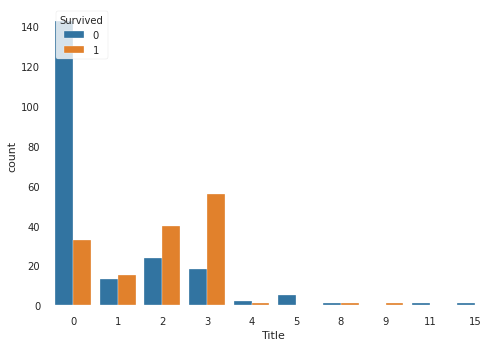

Middle class passengers who embarked from Cherbourg + Title VS survived


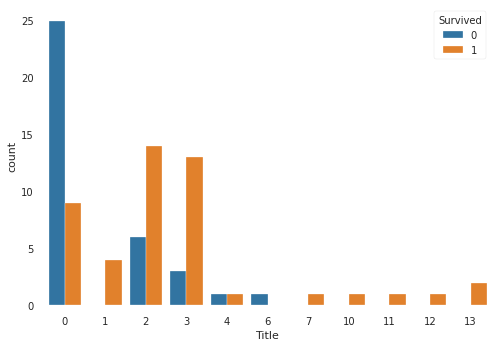

Poor passengers who embarked from Southampton + Title VS survived


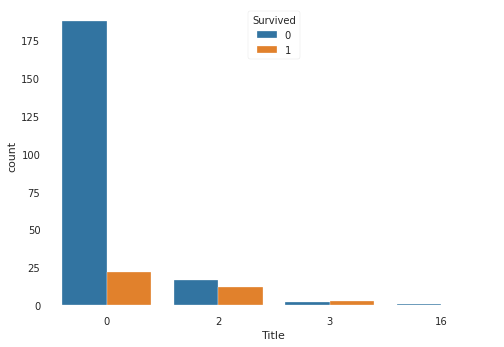

Poor passengers who embarked from Cherbourg + Title VS survived


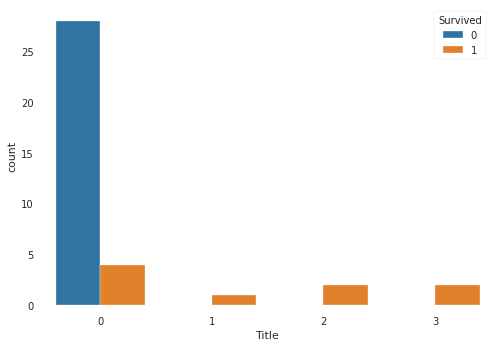

In [20]:
# Passengers who embarked from Souhtampton seem to have higher chances of survive
# Cherbourg and Southampton have higher chances give the best chances of surviving
# To grab some significance, let's filter by genger
aa = sns.countplot(x='Title', hue='Survived', data=df.query('Rich==1 & Embarked==0'))
print('Rich passengers who embarked from Southampton + Title VS survived')
plt.show()
aa = sns.countplot(x='Title', hue='Survived', data=df.query('Rich==1 & Embarked==1'))
print('Rich passengers who embarked from Cherbourg + Title VS survived')
plt.show()

aa = sns.countplot(x='Title', hue='Survived', data=df.query('MiddleClass==1 & Embarked==0'))
print('Middle class passengers who embarked from Southampton + Title VS survived')
plt.show()
aa = sns.countplot(x='Title', hue='Survived', data=df.query('MiddleClass==1 & Embarked==1'))
print('Middle class passengers who embarked from Cherbourg + Title VS survived')
plt.show()

aa = sns.countplot(x='Title', hue='Survived', data=df.query('Poor==1 & Embarked==0'))
print('Poor passengers who embarked from Southampton + Title VS survived')
plt.show()
aa = sns.countplot(x='Title', hue='Survived', data=df.query('Poor==1 & Embarked==1'))
print('Poor passengers who embarked from Cherbourg + Title VS survived')
plt.show()

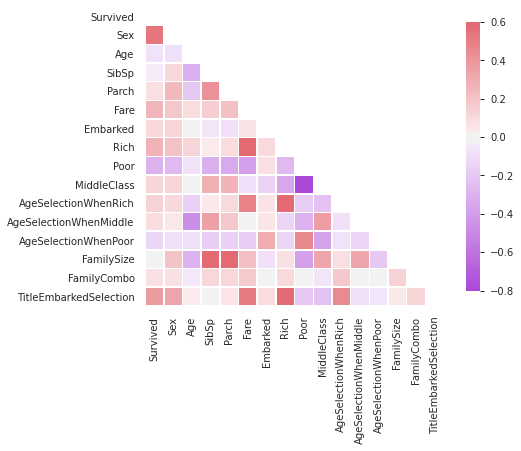

In [21]:
# Fantastic, The significance of data is now clearly amazing, it will help us reach better accuracy
df = create_titleembarked_category(df)

# Let's check our correlation graph again
correlation_graph(df)


In [22]:
# Wonderful, see the high correlation between TitleEmbarkedSelection and Survival rate?
# Now let's focus on another data we did not experiment and that is Ticket
# We will just see if we can extract something from that
print(df['Ticket'].values)

['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '349909' '347077' '2631' '19950' '330959'
 '349216' 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789'
 '2677' 'A./5. 2152' '345764' '2651' '7546' '11668' '349253'
 'SC/Paris 2123' '330958' 'S.C./A.4. 23567' '370371' '14311' '2662'
 '349237' '3101295' 'A/4. 39886' 'PC 17572' '2926' '113509' '19947'
 'C.A. 31026' '2697' 'C.A. 34651' 'CA 2144' '2669' '113572' '36973'
 '347088' 'PC 17605' '2661' 'C.A. 29395' 'S.P. 3464' '3101281' '315151'
 'C.A. 33111' 'CA 2144' 'S.O.C. 14879' '2680' '1601' '348123' '349208'
 '374746' '248738' '364516' '345767' '345779' '330932' '113059'
 'SO/C 14885' '3101278' 'W./C. 6608' 'SOTON/OQ 392086' '19950' '343275'
 '343276' '347466' 'W.E.P. 5734' 'C.A. 2315' '364500' '374910' 'PC 17754'
 'PC 17759' '231919' '244367' 

In [23]:
# What I observe is we have various categories of tickets:
#  1. Tickets with numbers only, from 3 digits to 7
#  2. Tickets with letters
# Maybe we can be successfull categorizing them, let's see
df = create_ticketcategory_category(df)

print(df['TicketCategory'].values)

[17 19 5 1 1 1 2 1 1 1 13 1 17 1 1 1 1 1 1 3 1 1 1 1 1 1 3 2 1 1 19 19 1 9
 19 1 3 24 1 3 3 2 1 21 1 31 1 2 3 1 0 18 19 3 1 2 9 3 9 15 3 1 2 1 19 3 9
 30 0 1 9 15 28 3 3 1 1 1 1 1 1 1 1 1 20 0 14 20 2 1 1 1 29 9 1 1 19 19 1
 1 1 1 2 3 0 1 1 1 1 1 1 3 1 3 3 5 1 2 19 1 28 33 1 2 2 3 1 19 3 1 1 20 17
 1 9 21 2 1 3 19 3 1 5 1 1 9 1 14 1 1 34 1 25 17 26 19 2 20 1 15 1 9 1 1 0
 1 1 1 19 3 1 1 1 5 2 1 3 19 1 8 15 21 1 1 1 1 1 1 1 1 1 2 1 1 19 19 1 3 1
 1 1 15 0 3 17 1 0 3 1 1 20 23 17 1 1 2 5 1 2 19 20 1 2 1 2 13 13 17 1 3 2
 1 1 1 9 14 2 9 2 21 3 1 14 5 3 2 1 1 2 1 1 1 1 17 1 3 19 1 19 1 1 1 1 1 1
 9 0 1 19 19 1 8 1 19 1 2 1 1 1 9 1 1 1 17 1 1 1 1 1 1 2 2 21 1 1 19 3 1 2
 19 3 1 8 1 17 1 2 19 13 19 2 19 1 1 23 1 1 2 2 2 17 1 1 1 15 19 1 2 1 1 1
 1 19 1 19 1 1 2 3 1 1 2 1 1 1 1 2 1 9 1 3 1 3 1 3 1 1 1 1 1 1 21 3 20 1
 19 1 3 2 19 2 0 1 19 1 19 19 1 3 1 19 3 5 1 1 28 15 2 1 21 1 1 0 2 13 1 1
 2 1 1 5 1 3 5 1 2 1 2 1 3 1 1 2 1 5 1 2 1 2 1 1 17 1 1 1 18 3 1 1 20 1 1
 21 5 2 1 14 2 2 9 23 1 1 1 2

Relation between Ticket category and survival rate


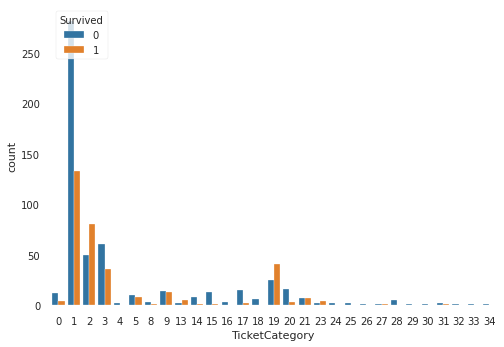

In [24]:
# Let's compare the ticket type with survival rate and see if we can spot a correlation
aa = sns.countplot(x='TicketCategory', hue='Survived', data=df)
print('Relation between Ticket category and survival rate')
plt.show()

Relation between Ticket category from rich passengers and survival rate


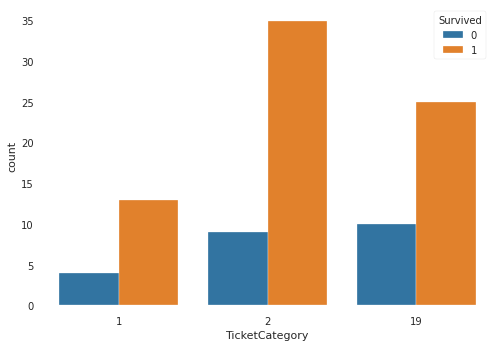

Relation between Ticket category from middle class passengers and survival rate


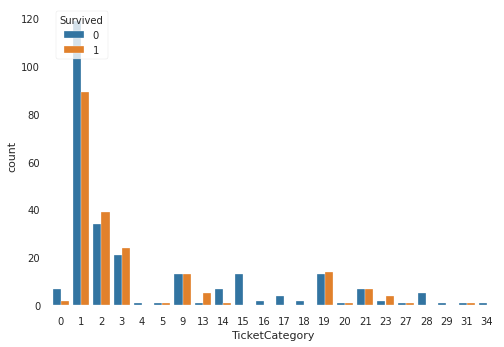

Relation between Ticket category from poor passengers and survival rate


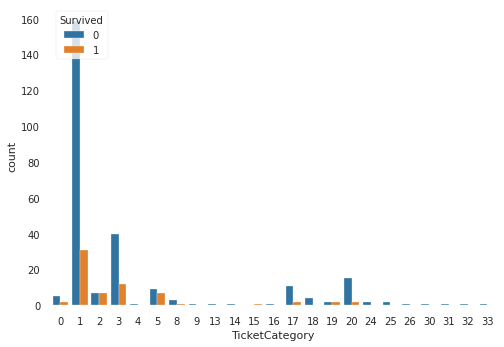

In [25]:
# It seems like with a six digit ticket number, you have the lowest chances to survive
# In the opposite, with a ticket number starting with "C ", your chances to survive are higher 
# But it's not enough, let's try to categorize them by social layer
aa = sns.countplot(x='TicketCategory', hue='Survived', data=df.query('Rich==1'))
print('Relation between Ticket category from rich passengers and survival rate')
plt.show()
aa = sns.countplot(x='TicketCategory', hue='Survived', data=df.query('MiddleClass==1'))
print('Relation between Ticket category from middle class passengers and survival rate')
plt.show()
aa = sns.countplot(x='TicketCategory', hue='Survived', data=df.query('Poor==1'))
print('Relation between Ticket category from poor passengers and survival rate')
plt.show()

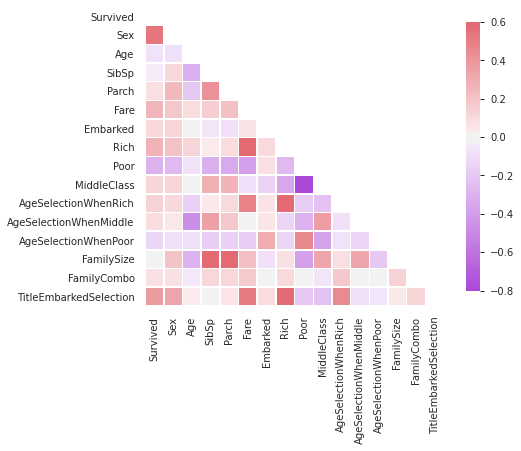

In [26]:
# Again, no real way to spot a clear trend, let's see what our correlation graph tells us
correlation_graph(df)

In [27]:
# Correlation is very low with survival rate
# But now, we have enough data to train our algorythm
# First, we remove columns with no correlation and that does not contains numbers
df = drop_remaining_irrelevant_columns(df)
print(df)

     Survived  Sex  SibSp  Parch     Fare  Embarked  Rich  Poor  MiddleClass  \
0           0    0      1      0   7.2500       0.0     0     1            0   
1           1    1      1      0  71.2833       1.0     0     0            1   
2           1    1      0      0   7.9250       0.0     0     1            0   
3           1    1      1      0  53.1000       0.0     0     0            1   
4           0    0      0      0   8.0500       0.0     0     1            0   
..        ...  ...    ...    ...      ...       ...   ...   ...          ...   
886         0    0      0      0  13.0000       0.0     0     0            1   
887         1    1      0      0  30.0000       0.0     0     0            1   
888         0    1      1      2  23.4500       0.0     0     0            1   
889         1    0      0      0  30.0000       1.0     0     0            1   
890         0    0      0      0   7.7500       2.0     0     1            0   

     AgeSelectionWhenRich  AgeSelection

Create directory AutoML_1
AutoML task to be solved: binary_classification
AutoML will use algorithms: ['CatBoost']
AutoML will optimize for metric: logloss
1_Default_CatBoost final logloss 0.000777144330637632 time 11.2 seconds
419
     Predicted  Survived  Score
0            0         0    1.0
1            1         1    1.0
2            1         1    1.0
3            0         0    1.0
4            1         1    1.0
..         ...       ...    ...
414          0         0    1.0
415          0         0    1.0
416          1         1    1.0
417          1         1    1.0
418          0         0    1.0

[419 rows x 3 columns]
Test MSE: 0.0


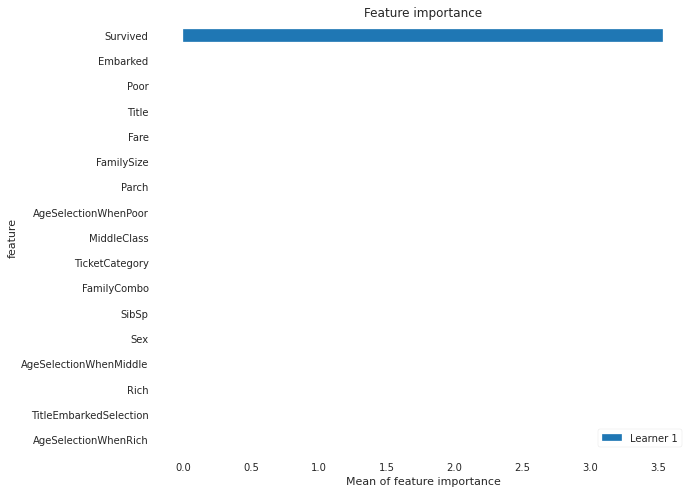

In [28]:
# GREAT !!!, now time to predict our results
Predict = autoMlPredict(df)

In [29]:
# We predict with 100% accuracy and 0.0007% error log on our own train dataset
# It does not mean, the predictions are 100% accurate on the test dataset
# Let's save our predictions first, we are going to add now our test to the train dataset for final prediction
save_predictions(Predict, './submission.csv')